In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [7]:
df = pd.read_csv("features_window1.csv")

X = df.drop(columns=['Activity'])
y = df['Activity']

# Encoding the target variable
y, class_labels = pd.factorize(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models to test
models = {
    'Logistic Regression': LogisticRegression(solver='lbfgs', max_iter=500),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(decision_function_shape='ovr', probability=True, random_state=42),
    "XGB": XGBClassifier(
        objective="multi:softmax",  # Use "multi:softprob" if you need class probabilities
        num_class=4,                # Number of classes in your target variable
        eval_metric="mlogloss",     # Evaluation metric
        random_state=42,            # For reproducibility
        n_estimators=100,           # Number of trees
        max_depth=6,                # Maximum depth of trees
        learning_rate=0.1           # Learning rate
    )
}

In [8]:
def train_and_evaluate_models(models, X_train_scaled, y_train, X_test_scaled, y_test):
    
    results = []

    # Fit models and evaluate performance
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        report = classification_report(y_test, y_pred, output_dict=True)
        
        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'classification_report': report
        })

    return results

In [9]:
def print_and_compare_confusion_matrices(results, class_labels):
    
    results = train_and_evaluate_models(models, X_train_scaled, y_train, X_test_scaled, y_test)
    
    for result in results:

        classification_report = result['classification_report']
        model_name = result['Model']

        y_pred = models[model_name].predict(X_test_scaled)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
        disp.plot(cmap='viridis')
        plt.title(f"Confusion Matrix for {model_name}")
        plt.show()    

In [10]:
def compare_results(results):
    # Print accuracy and F1 scores for all models
    print("Model Performance Summary:\n")
    for result in results:
        model_name = result["Model"]
        accuracy = result["Accuracy"]
        f1_score = result["F1 Score"]
        print(f"{model_name}:\n  - Accuracy: {accuracy:.4f}\n  - F1 Score: {f1_score:.4f}\n")


# Performance Results for All Features:

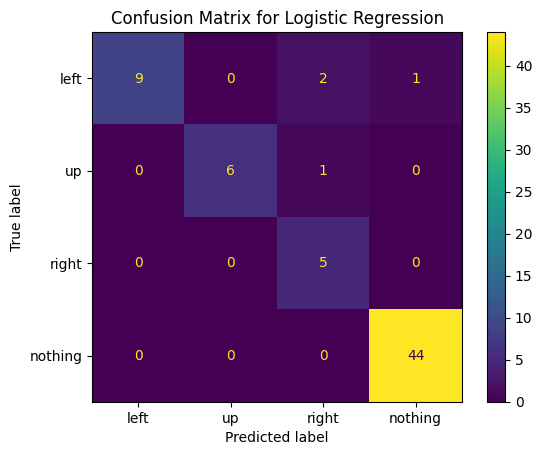

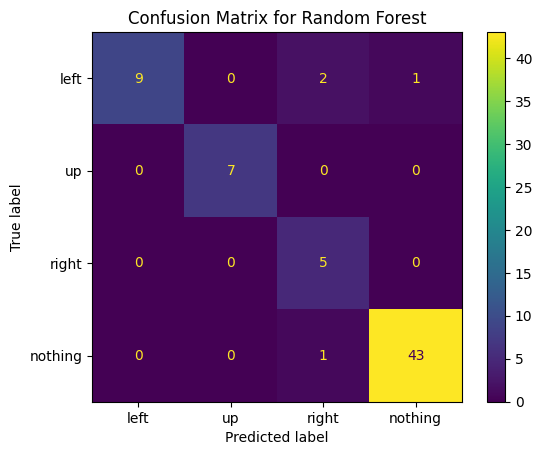

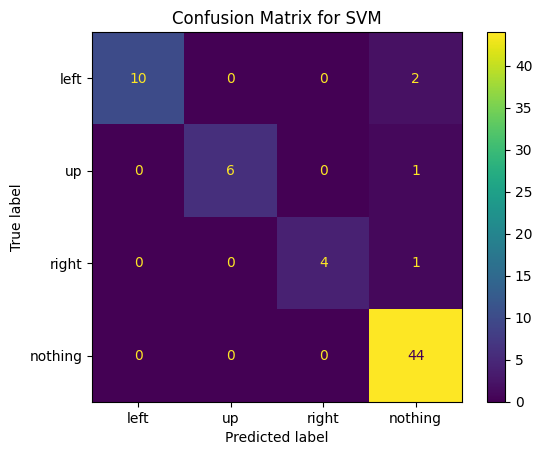

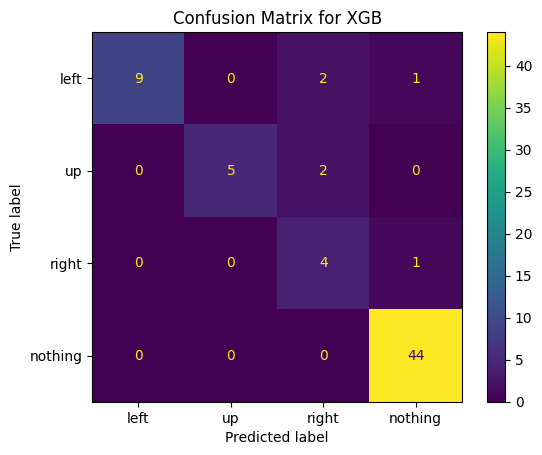

Model Performance Summary:

Logistic Regression:
  - Accuracy: 0.9412
  - F1 Score: 0.9426

Random Forest:
  - Accuracy: 0.9412
  - F1 Score: 0.9431

SVM:
  - Accuracy: 0.9412
  - F1 Score: 0.9397

XGB:
  - Accuracy: 0.9118
  - F1 Score: 0.9150



In [11]:
results = train_and_evaluate_models(models, X_train_scaled, y_train, X_test_scaled, y_test)
print_and_compare_confusion_matrices(results, class_labels)
compare_results(results)

# Sequential Feature Selection:

In [12]:
# Sequential Feature Selection with Logistic Regression
sfs = SequentialFeatureSelector(
    LogisticRegression(solver='lbfgs', max_iter=500),
    n_features_to_select='auto',
    direction='forward',
    scoring='accuracy',
    cv=5
)
sfs.fit(X_train_scaled, y_train)
selected_features = X.columns[sfs.get_support()]

# Display Selected Features
selected_features_list = selected_features.tolist()
selected_features_list

['std_x', 'median_x', 'root_mean_square_x', 'std_y', 'std_z', 'median_z']

In [13]:
X_train_filtered = X_train[selected_features].copy()
X_test_filtered = X_test[selected_features].copy()

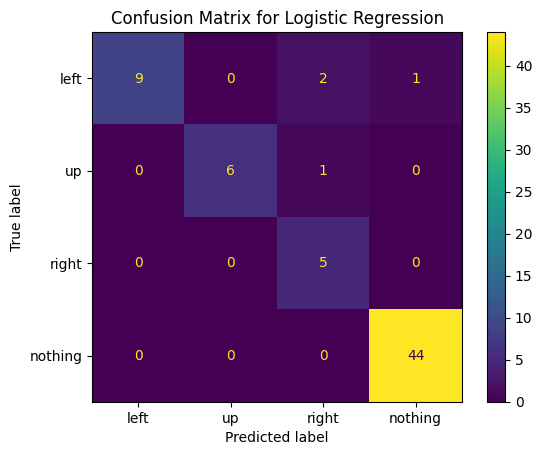

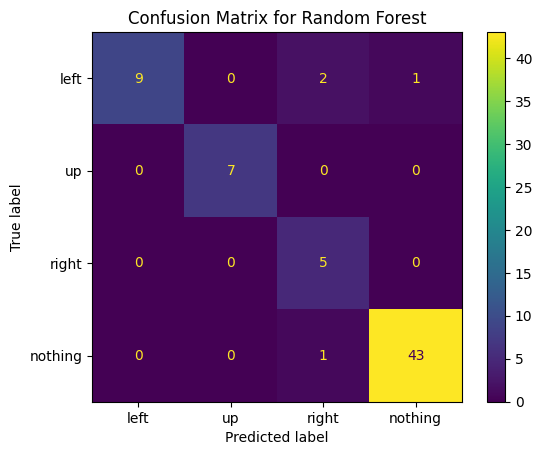

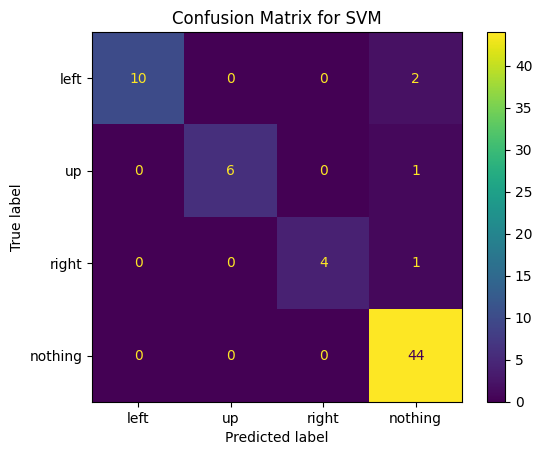

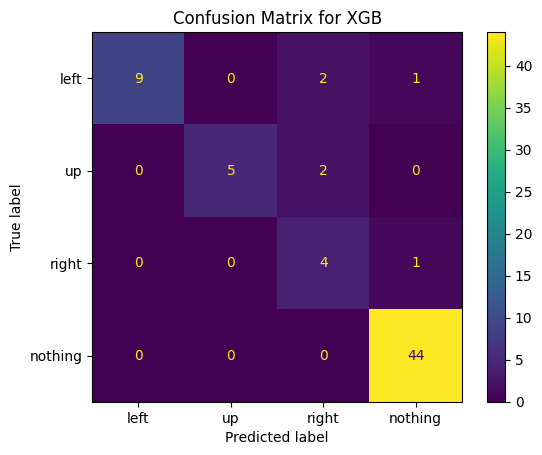

Model Performance Summary:

Logistic Regression:
  - Accuracy: 0.9412
  - F1 Score: 0.9402

Random Forest:
  - Accuracy: 0.8971
  - F1 Score: 0.8975

SVM:
  - Accuracy: 0.9118
  - F1 Score: 0.9072

XGB:
  - Accuracy: 0.8824
  - F1 Score: 0.8798



In [14]:
results = train_and_evaluate_models(models, X_train_filtered, y_train, X_test_filtered, y_test)
print_and_compare_confusion_matrices(results, class_labels)
compare_results(results)